# Bayesian analysis of the number of Bids in eBay coin auctions
Linköping University, Fall 2019.

Author: Mattias Villani, Linköping and Stockholm University, http://mattiasvillani.com

The dataset contains data from 1000 auctions of collector coins. The dataset was collected and first analyzed in 

Wegmann and Villani. 'Bayesian Inference in Structural Second-Price Common Value Auctions', *Journal of Business & Economic Statistics*, 2011.

Import modules, load the data and explore the data by plotting

In [1]:
# Imports and load the data
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(seed=123) # Set the seed for reproducibility

# Load the data
eBayData = pd.read_csv('https://github.com/STIMALiU/ml4industry/raw/master/Labs/eBayData.csv', sep = ',')
nBids = eBayData['nBids']

The model these data using a **Poisson distribution**: 
$$y_1,...,y_n \vert \theta \overset{iid}{\sim} \mathrm{Poisson}(\theta).$$ 
Let's use a conjugate Gamma prior, so the posterior is nice:\
**Prior**: $\theta  \sim \mathrm{Gamma}(\alpha, \beta)$\
**Posterior**: $\theta \vert y_1,\ldots,y_n \sim \mathrm{Gamma}(\alpha + \sum_{i=1}^n y_i, \beta + n)$

Number of data points = 1000
Sum of number of counts = 3635
Mean number of counts = 3.635
Prior mean = 4.0
Prior standard deviation = 2.8284271247461903
Equal tail 95% prior interval: (0.48441855708793014, 11.143286781877796)
Posterior mean = 3.635
Posterior standard deviation = 0.06027740643004339
Equal tail 95% posterior interval: (3.5179903738284697, 3.7542677655304297)


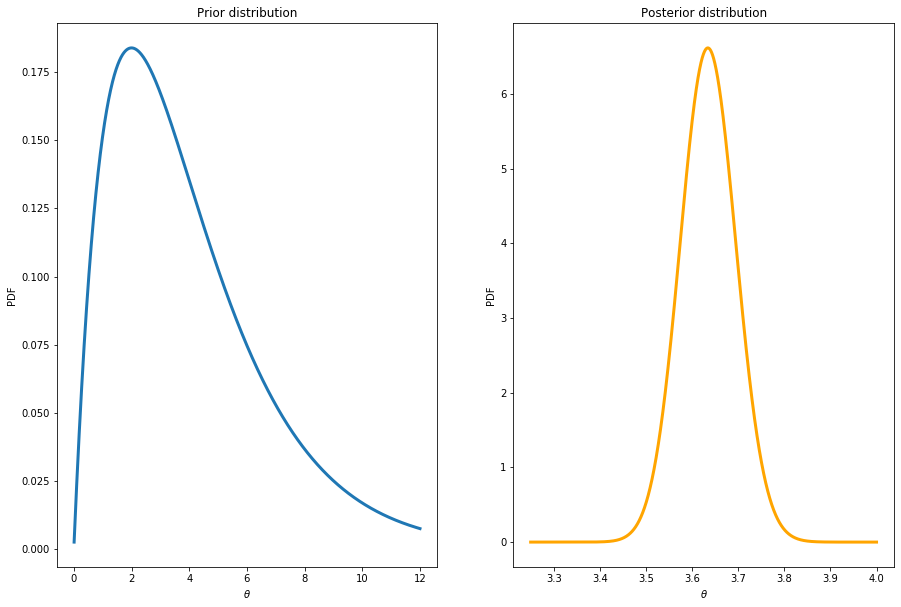

In [6]:
# Define the Gamma distribution in the rate parametrization
def gammaPDF(x, alpha, beta):
    return(sps.gamma.pdf(x, a = alpha, scale = 1/beta))


def PostPoisson(y, alphaPrior, betaPrior, thetaPriorGrid = None, thetaPostGrid = None):

# Compute Prior density and posterior
    priorDens = gammaPDF(x = thetaPriorGrid, alpha = alphaPrior, beta = betaPrior)
    n = len(y)
    alphaPost = alphaPrior + np.sum(y)
    betaPost = betaPrior + n
    postDens = gammaPDF(x = thetaPostGrid, alpha = alphaPost, beta = betaPost)
    
    print('Number of data points = ' + str(len(y)))
    print('Sum of number of counts = ' + str(np.sum(y)))
    print('Mean number of counts = ' + str(np.mean(y)))
    print('Prior mean = ' + str(alphaPrior/betaPrior))
    print('Prior standard deviation = '+ str(np.sqrt(alphaPrior/(betaPrior**2))))
    print('Equal tail 95% prior interval: ' + str(sps.gamma.interval(0.95, a = alphaPrior, scale = 1/betaPrior)))  
    print('Posterior mean = ' + str(round(alphaPost/betaPost,3)))
    print('Posterior standard deviation = '+ str(np.sqrt(    (alphaPrior+np.sum(y))/  ((betaPrior+n)**2)  )    ))
    print('Equal tail 95% posterior interval: ' + str(sps.gamma.interval(0.95, a = alphaPost, scale = 1/betaPost)))  

    if (thetaPriorGrid.any() != None):
        fig, ax = plt.subplots(1, 2, figsize=(15, 10))
        h1, = ax[0].plot(thetaPriorGrid, priorDens, lw = 3);
        ax[0].set_xlabel(r'$\theta$');ax[0].set_ylabel('PDF');
        ax[0].set_title('Prior distribution');

        h2, = ax[1].plot(thetaPostGrid, postDens, lw = 3, color ="orange");
        ax[1].set_xlabel(r'$\theta$');ax[1].set_ylabel('PDF');
        ax[1].set_title('Posterior distribution');

alphaPrior = 2
betaPrior = 1/2
PostPoisson(y = nBids, alphaPrior = 2, betaPrior = 1/2,
            thetaPriorGrid = np.linspace(0.01,12,10000), thetaPostGrid = np.linspace(3.25,4,10000))
plt.savefig('../../Slides/Images/PoissonAnalysisAll.pdf')

Let's plot the data along with the fitted Poisson model. We'll keep things simple and plot the fit for the posterior mean of $\theta$.

In [7]:
def plotPoissonFit(y, alphaPrior, betaPrior):
    
    # Plot data
    maxY = np.max(y)
    yGrid = np.arange(maxY)
    probs = [np.sum(y==k)/len(y) for k in range(maxY)]
    h1 = plt.bar(yGrid, probs, alpha = 0.3);
    plt.xlabel('y');plt.ylabel('PMF');
    plt.xticks(yGrid);
    plt.title('Fitted Poisson model based on posterior mean estimate');
    
    # Compute posterior mean
    n = len(y)
    alphaPost = alphaPrior + np.sum(y)
    betaPost = betaPrior + n
    postMean = alphaPost/betaPost
    
    # Plot the fit based on the posterior mean of theta
    poisFit = sps.poisson.pmf(yGrid, mu = postMean) 
    plt.plot(yGrid, poisFit, color = 'orange', lw = 3)

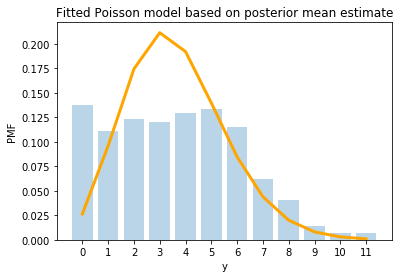

In [8]:
# Plot the fit for all bids
alphaPrior = 2
betaPrior = 1/2
plotPoissonFit(y = nBids, alphaPrior = alphaPrior, betaPrior = betaPrior)
plt.savefig('../../Slides/Images/FitPoissonDataAll.pdf')

Wow, that's are terrible fit! This data does not look at all like a Poisson distribution. We will later model the number of bids using a Poisson *regression* where we take into account several explanatory variables. But, for now, let's split the auctions in two subsets:\
i) auctions with low reservation price in relation to the item's book value (MinBidShare<=0)\
ii) auctions with high reservation price in relation to the item's book value (MinBidShare>0)

Number of data points = 550
Sum of number of counts = 2927
Mean number of counts = 5.321818181818182
Prior mean = 4.0
Prior standard deviation = 2.8284271247461903
Equal tail 95% prior interval: (0.48441855708793014, 11.143286781877796)
Posterior mean = 5.321
Posterior standard deviation = 0.09831105633231468
Equal tail 95% posterior interval: (5.129657752003312, 5.5150184684772965)


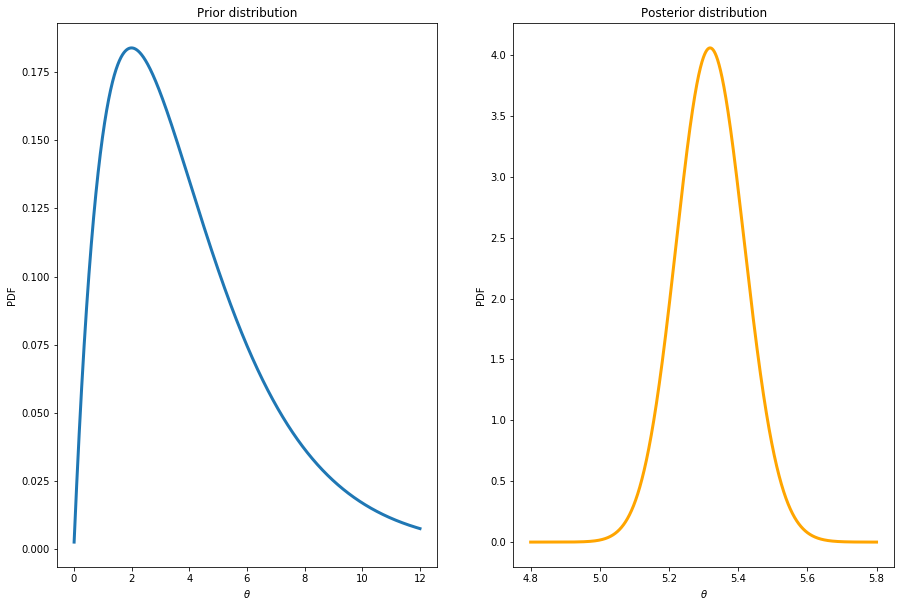

In [9]:
# Auctions with low reservation prices:
nBidsLow = nBids[eBayData['MinBidShare']<=0]

PostPoisson(y = nBidsLow, alphaPrior = 2, betaPrior = 1/2,
            thetaPriorGrid = np.linspace(0.01,12,10000), thetaPostGrid = np.linspace(4.8,5.8,10000))
plt.savefig('../../Slides/Images/PoissonAnalysisLow.pdf')

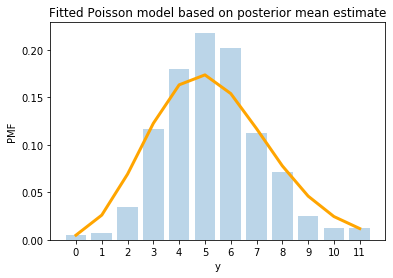

In [10]:
# Plot the fit for low bids
plotPoissonFit(y = nBidsLow, alphaPrior = alphaPrior, betaPrior = betaPrior)
plt.savefig('../../Slides/Images/FitPoissonDataLow.pdf')

Number of data points = 450
Sum of number of counts = 708
Mean number of counts = 1.5733333333333333
Prior mean = 4.0
Prior standard deviation = 2.8284271247461903
Equal tail 95% prior interval: (0.48441855708793014, 11.143286781877796)
Posterior mean = 1.576
Posterior standard deviation = 0.05914722572463586
Equal tail 95% posterior interval: (1.4622167615099835, 1.6940409831159082)


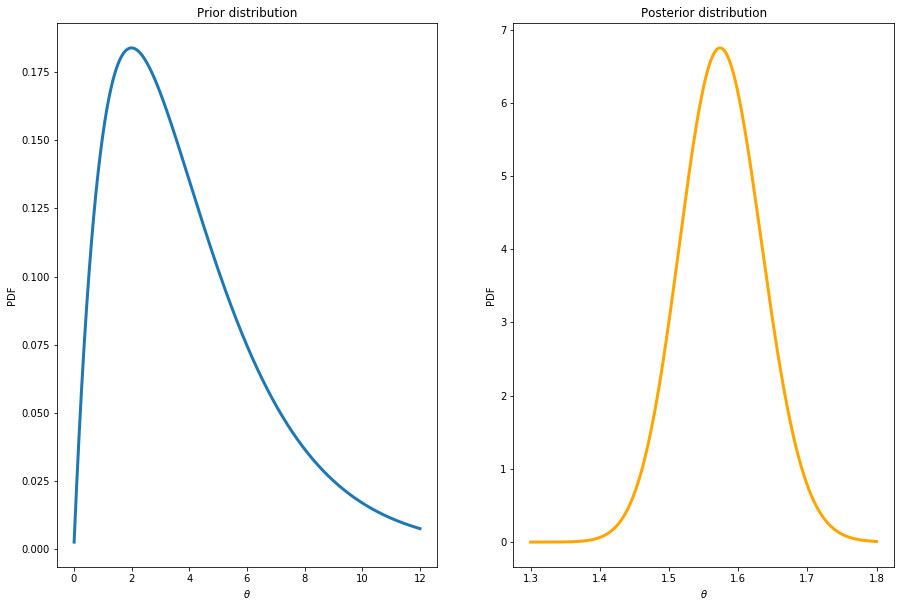

In [11]:
# Auctions with low reservation prices:
nBidsHigh = nBids[eBayData['MinBidShare']>0]

PostPoisson(y = nBidsHigh, alphaPrior = 2, betaPrior = 1/2,
            thetaPriorGrid = np.linspace(0.01,12,10000), thetaPostGrid = np.linspace(1.3,1.8,10000))
plt.savefig('../../Slides/Images/PoissonAnalysisHigh.pdf')

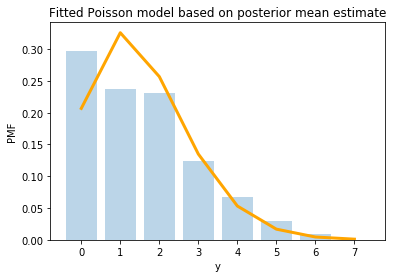

In [12]:
# Plot the fit for high bids
plotPoissonFit(y = nBidsHigh, alphaPrior = alphaPrior, betaPrior = betaPrior)
plt.savefig('../../Slides/Images/FitPoissonDataHigh.pdf')

So, separating the bids into dataset with low and high reservation prices makes the Poisson model a lot better for the data. Later, we will use a Poisson regression with 
reservation price as one of the features, which an even more fine grained analysis. 

This looks a lot better. The data for these two subpopulations look like something we can model with Poisson distributions. Let's try that using a conjugate Gamma prior:\
**Prior**: $\theta  \sim \mathrm{Gamma}(\alpha, \beta)$\
**Posterior**: $\theta \vert y_1,\ldots,y_n \sim \mathrm{Gamma}(\alpha + \sum_{i=1}^n y_i, \beta + n)$

### Prior
We start with a Gamma prior with mean of 2 and rate parameter equal to 1/2, both for the low and high reservation price auctions. The prior looks like this:

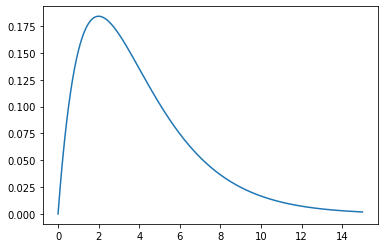

In [13]:
# Define the Gamma distribution in the rate parametrization
def gammaPDF(x, alpha, beta):
    return(sps.gamma.pdf(x, a = alpha, scale = 1/beta))

thetaGrid = np.linspace(0.001,15,1000)
alphaPrior = 2
betaPrior = 1/2
priorDens = gammaPDF(x = thetaGrid, alpha = alphaPrior, beta = betaPrior)
plt.plot(thetaGrid, priorDens);

In [14]:
n = len(nBids)
alphaPost = alphaPrior + np.sum(nBids)
betaPost = betaPrior + n
thetaGrid = np.linspace(0.000001,15,10000)
postDens = gammaPDF(x = thetaGrid, alpha = alphaPost, beta = betaPost)

In [15]:
spacing = thetaGrid[1]-thetaGrid[0] 
postDens = (postDens/np.sum(postDens))
idxDesc = (-postDens).argsort()
HPDregion = np.sort(thetaGrid[idxDesc[np.cumsum(postDens[idxDesc])<=0.95]])
(HPDregion.min(),HPDregion.max())

(3.5178525506550655, 3.7518759373937396)